# E-commerce Analytics with SQL & Python (Colab)

This notebook simulates a small e-commerce database and uses SQL + Python (SQLite + pandas) to answer typical business questions.

**Goals:**
- Design a simple e-commerce data model (customers, products, orders, payments).
- Create and populate the database using SQLite inside Google Colab.
- Run SQL queries to analyse revenue, marketing channels, product categories, and customer behaviour.
- Visualise key metrics with basic charts (monthly revenue, revenue by channel, etc.).


## 1. Setup

In this section we:
- Import Python libraries.
- Create a SQLite connection (local file `ecommerce_analytics.db`).
- Define a small helper function to run SQL queries and return DataFrames.


In [10]:
import sqlite3
import pandas as pd

# Create (or connect to) a local SQLite database file
conn = sqlite3.connect("ecommerce_analytics.db")

# Create a cursor to execute SQL commands
cur = conn.cursor()

print("Connected to SQLite!")


Connected to SQLite!


## 2. Schema Creation

Here we define the e-commerce data model:

- `product_category`: product categories
- `product`: products and prices
- `customer`: customers and basic attributes
- `orders`: order header (who bought, when, from which marketing channel)
- `order_item`: order lines (which products and quantities)
- `payment`: payment information

We will drop tables if they already exist and recreate them from scratch.

In [36]:
schema_sql = """
DROP TABLE IF EXISTS payment;
DROP TABLE IF EXISTS order_item;
DROP TABLE IF EXISTS orders;
DROP TABLE IF EXISTS product;
DROP TABLE IF EXISTS product_category;
DROP TABLE IF EXISTS customer;

-- Product categories
CREATE TABLE product_category (
    category_id     INTEGER PRIMARY KEY,
    category_name   TEXT NOT NULL
);

-- Products
CREATE TABLE product (
    product_id   INTEGER PRIMARY KEY,
    category_id  INTEGER NOT NULL,
    product_name TEXT NOT NULL,
    brand        TEXT,
    unit_price   NUMERIC(10,2) NOT NULL,
    created_at   TEXT,
    FOREIGN KEY (category_id) REFERENCES product_category(category_id)
);

-- Customers
CREATE TABLE customer (
    customer_id   INTEGER PRIMARY KEY,
    full_name     TEXT NOT NULL,
    email         TEXT UNIQUE,
    country       TEXT,
    signup_date   TEXT NOT NULL,
    gender        TEXT,
    age_group     TEXT
);

-- Orders (order header)
CREATE TABLE orders (
    order_id          INTEGER PRIMARY KEY,
    customer_id       INTEGER NOT NULL,
    order_date        TEXT NOT NULL,
    status            TEXT NOT NULL,     -- 'completed','canceled','pending'
    marketing_channel TEXT,              -- 'Paid Search','Organic','Email',...
    shipping_country  TEXT,
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);

-- Order items (order lines)
CREATE TABLE order_item (
    order_item_id INTEGER PRIMARY KEY,
    order_id      INTEGER NOT NULL,
    product_id    INTEGER NOT NULL,
    quantity      INTEGER NOT NULL,
    unit_price    NUMERIC(10,2) NOT NULL,
    FOREIGN KEY (order_id)   REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES product(product_id)
);

-- Payments
CREATE TABLE payment (
    payment_id     INTEGER PRIMARY KEY,
    order_id       INTEGER NOT NULL,
    payment_date   TEXT NOT NULL,
    payment_method TEXT NOT NULL,       -- 'credit_card','paypal','pix',...
    amount         NUMERIC(10,2) NOT NULL,
    status         TEXT NOT NULL,       -- 'paid','pending','refunded'
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
);
"""

cur.executescript(schema_sql)
conn.commit()
print("Tables created!")


Tables created!


## 3. Sample Data Insertion

We now insert a small but consistent set of sample data:

- 3 product categories (Electronics, Home Office, Sports & Fitness)
- 6 products
- 5 customers
- 6 orders (with different statuses and marketing channels)
- Order items connected to those orders
- Payments, including paid, pending and refunded statuses

This dataset is intentionally small so it is easy to inspect and reason about.


In [37]:
data_sql = """
-- Categories
INSERT INTO product_category (category_id, category_name) VALUES
(1, 'Electronics'),
(2, 'Home Office'),
(3, 'Sports & Fitness');

-- Products
INSERT INTO product (product_id, category_id, product_name, brand, unit_price, created_at) VALUES
(1, 1, 'Wireless Mouse',        'LogiTechy',  25.00, '2024-02-01'),
(2, 1, 'Mechanical Keyboard',   'KeyMaster',  79.00, '2024-02-01'),
(3, 1, 'USB-C Hub 6-in-1',      'HyperLink',  39.00, '2024-02-10'),
(4, 2, 'Ergonomic Office Chair','ComfortSeat',199.00, '2024-02-15'),
(5, 2, 'Standing Desk',         'UpRight',    399.00, '2024-02-20'),
(6, 3, 'Fitness Tracker Watch', 'FitPulse',   149.00, '2024-02-25');

-- Customers
INSERT INTO customer (
    customer_id, full_name, email, country, signup_date, gender, age_group
) VALUES
(1, 'Anna de Vries',   'anna@example.com',   'Netherlands', '2024-02-20', 'F', '25-34'),
(2, 'João Silva',      'joao@example.com',   'Portugal',    '2024-02-22', 'M', '25-34'),
(3, 'Maria Santos',    'maria@example.com',  'Brazil',      '2024-03-01', 'F', '35-44'),
(4, 'Lukas Müller',    'lukas@example.com',  'Germany',     '2024-03-05', 'M', '25-34'),
(5, 'Claire Dubois',   'claire@example.com', 'France',      '2024-03-10', 'F', '18-24');

-- Orders
INSERT INTO orders (
    order_id, customer_id, order_date, status, marketing_channel, shipping_country
) VALUES
(1, 1, '2024-03-01 09:15:00', 'completed', 'Paid Search', 'Netherlands'),
(2, 2, '2024-03-02 10:05:00', 'completed', 'Organic',     'Portugal'),
(3, 1, '2024-03-15 14:30:00', 'completed', 'Email',       'Netherlands'),
(4, 3, '2024-03-20 16:45:00', 'canceled',  'Paid Social', 'Brazil'),
(5, 4, '2024-04-05 11:20:00', 'completed', 'Organic',     'Germany'),
(6, 5, '2024-04-10 18:40:00', 'pending',   'Referral',    'France');

-- Order items
INSERT INTO order_item (order_item_id, order_id, product_id, quantity, unit_price) VALUES
(1, 1, 1, 1, 25.00),  -- Mouse
(2, 1, 2, 1, 79.00),  -- Keyboard
(3, 2, 4, 1, 199.00), -- Office Chair
(4, 3, 5, 1, 399.00), -- Standing Desk
(5, 3, 3, 2, 39.00),  -- 2x USB-C Hub
(6, 4, 6, 1, 149.00), -- Fitness Tracker (canceled)
(7, 5, 1, 2, 25.00),  -- 2x Mouse
(8, 5, 3, 1, 39.00),  -- 1x USB-C Hub
(9, 6, 4, 1, 199.00); -- Office Chair (pending)

-- Payments
INSERT INTO payment (
    payment_id, order_id, payment_date, payment_method, amount, status
) VALUES
(1, 1, '2024-03-01 09:20:00', 'credit_card', 104.00, 'paid'),
(2, 2, '2024-03-02 10:10:00', 'credit_card', 199.00, 'paid'),
(3, 3, '2024-03-15 14:35:00', 'paypal',      477.00, 'paid'),
(4, 4, '2024-03-20 16:50:00', 'pix',         149.00, 'refunded'),
(5, 5, '2024-04-05 11:25:00', 'credit_card', 89.00,  'paid'),
(6, 6, '2024-04-10 18:45:00', 'paypal',      199.00, 'pending');
"""

cur.executescript(data_sql)
conn.commit()
print("Sample data inserted!")

Sample data inserted!


## 4. Business Analysis Queries

In this section we use SQL to answer typical business questions for an e-commerce:

1. **Monthly revenue** – How much do we earn per month?
2. **Revenue by marketing channel** – Which channels drive more revenue?
3. **Average Order Value (AOV)** – How much does a completed order generate on average?
4. **Revenue by product category** – Which categories are more important for the business?
5. **Repeat customers** – What percentage of customers make 2+ completed orders?

For each question we:
- Run a SQL query.
- Inspect the result in a DataFrame.
- Optionally plot a quick chart.


In [29]:
query_revenue_month = """
SELECT
    substr(payment_date, 1, 7) AS year_month,  -- YYYY-MM
    SUM(amount) AS revenue
FROM payment
WHERE status = 'paid'
GROUP BY substr(payment_date, 1, 7)
ORDER BY year_month;
"""

df_revenue_month = run_sql(query_revenue_month)
df_revenue_month


,year_month,revenue
0,2024-03,780
1,2024-04,89


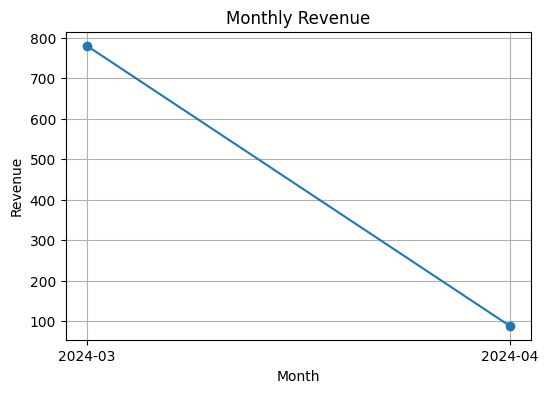

In [30]:
plt.figure(figsize=(6,4))
plt.plot(df_revenue_month["year_month"], df_revenue_month["revenue"], marker="o")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Monthly Revenue")
plt.grid(True)
plt.show()


In [31]:
query_revenue_channel = """
SELECT
    o.marketing_channel,
    SUM(p.amount) AS revenue
FROM payment p
JOIN orders o ON p.order_id = o.order_id
WHERE p.status = 'paid'
GROUP BY o.marketing_channel
ORDER BY revenue DESC;
"""

df_revenue_channel = run_sql(query_revenue_channel)
df_revenue_channel


,marketing_channel,revenue
0,Email,477
1,Organic,288
2,Paid Search,104


In [32]:
query_aov = """
SELECT
    AVG(order_total) AS avg_order_value
FROM (
    SELECT
        o.order_id,
        SUM(oi.quantity * oi.unit_price) AS order_total
    FROM orders o
    JOIN order_item oi ON o.order_id = oi.order_id
    WHERE o.status = 'completed'
    GROUP BY o.order_id
) t;
"""

df_aov = run_sql(query_aov)
df_aov


,avg_order_value
0,217.25


In [33]:
query_revenue_category = """
SELECT
    pc.category_name,
    SUM(oi.quantity * oi.unit_price) AS revenue
FROM orders o
JOIN order_item oi       ON o.order_id = oi.order_id
JOIN product p           ON oi.product_id = p.product_id
JOIN product_category pc ON p.category_id = pc.category_id
WHERE o.status = 'completed'
GROUP BY pc.category_name
ORDER BY revenue DESC;
"""

df_revenue_category = run_sql(query_revenue_category)
df_revenue_category


,category_name,revenue
0,Home Office,598
1,Electronics,271


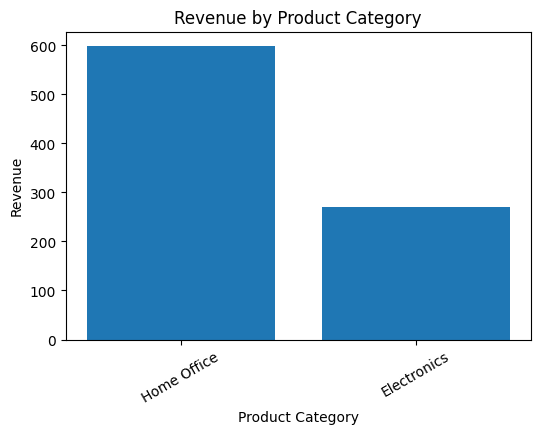

In [34]:
plt.figure(figsize=(6,4))
plt.bar(df_revenue_category["category_name"], df_revenue_category["revenue"])
plt.xlabel("Product Category")
plt.ylabel("Revenue")
plt.title("Revenue by Product Category")
plt.xticks(rotation=30)
plt.show()

In [35]:
query_repeat_customers = """
WITH completed_orders AS (
    SELECT
        customer_id,
        COUNT(*) AS num_orders
    FROM orders
    WHERE status = 'completed'
    GROUP BY customer_id
),
agg AS (
    SELECT
        COUNT(*) AS total_customers,
        SUM(CASE WHEN num_orders >= 2 THEN 1 ELSE 0 END) AS repeat_customers
    FROM completed_orders
)
SELECT
    total_customers,
    repeat_customers,
    ROUND(
        1.0 * repeat_customers / NULLIF(total_customers, 0),
        4
    ) AS repeat_rate
FROM agg;
"""

df_repeat = run_sql(query_repeat_customers)
df_repeat


,total_customers,repeat_customers,repeat_rate
0,3,1,0.3333


## 5. Full Dataset (Appendix)

For reference, this section shows the full content of all tables in the e-commerce database:

- `product_category`
- `product`
- `customer`
- `orders`
- `order_item`
- `payment`


In [38]:
from IPython.display import display

tables = [
    "product_category",
    "product",
    "customer",
    "orders",
    "order_item",
    "payment"
]

for t in tables:
    print(f"===== {t.upper()} =====")
    df = run_sql(f"SELECT * FROM {t};")
    display(df)
    print("\n")


===== PRODUCT_CATEGORY =====


,category_id,category_name
0,1,Electronics
1,2,Home Office
2,3,Sports & Fitness




===== PRODUCT =====


,product_id,category_id,product_name,brand,unit_price,created_at
0,1,1,Wireless Mouse,LogiTechy,25,2024-02-01
1,2,1,Mechanical Keyboard,KeyMaster,79,2024-02-01
2,3,1,USB-C Hub 6-in-1,HyperLink,39,2024-02-10
3,4,2,Ergonomic Office Chair,ComfortSeat,199,2024-02-15
4,5,2,Standing Desk,UpRight,399,2024-02-20
5,6,3,Fitness Tracker Watch,FitPulse,149,2024-02-25




===== CUSTOMER =====


,customer_id,full_name,email,country,signup_date,gender,age_group
0,1,Anna de Vries,anna@example.com,Netherlands,2024-02-20,F,25-34
1,2,João Silva,joao@example.com,Portugal,2024-02-22,M,25-34
2,3,Maria Santos,maria@example.com,Brazil,2024-03-01,F,35-44
3,4,Lukas Müller,lukas@example.com,Germany,2024-03-05,M,25-34
4,5,Claire Dubois,claire@example.com,France,2024-03-10,F,18-24




===== ORDERS =====


,order_id,customer_id,order_date,status,marketing_channel,shipping_country
0,1,1,2024-03-01 09:15:00,completed,Paid Search,Netherlands
1,2,2,2024-03-02 10:05:00,completed,Organic,Portugal
2,3,1,2024-03-15 14:30:00,completed,Email,Netherlands
3,4,3,2024-03-20 16:45:00,canceled,Paid Social,Brazil
4,5,4,2024-04-05 11:20:00,completed,Organic,Germany
5,6,5,2024-04-10 18:40:00,pending,Referral,France




===== ORDER_ITEM =====


,order_item_id,order_id,product_id,quantity,unit_price
0,1,1,1,1,25
1,2,1,2,1,79
2,3,2,4,1,199
3,4,3,5,1,399
4,5,3,3,2,39
5,6,4,6,1,149
6,7,5,1,2,25
7,8,5,3,1,39
8,9,6,4,1,199




===== PAYMENT =====


,payment_id,order_id,payment_date,payment_method,amount,status
0,1,1,2024-03-01 09:20:00,credit_card,104,paid
1,2,2,2024-03-02 10:10:00,credit_card,199,paid
2,3,3,2024-03-15 14:35:00,paypal,477,paid
3,4,4,2024-03-20 16:50:00,pix,149,refunded
4,5,5,2024-04-05 11:25:00,credit_card,89,paid
5,6,6,2024-04-10 18:45:00,paypal,199,pending


In [39]:
for t in tables:
    df = run_sql(f"SELECT * FROM {t};")
    filename = f"{t}.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {filename}")


Saved product_category.csv
Saved product.csv
Saved customer.csv
Saved orders.csv
Saved order_item.csv
Saved payment.csv


In [43]:
import os

os.makedirs("sample_data", exist_ok=True)

tables = [
    "product_category",
    "product",
    "customer",
    "orders",
    "order_item",
    "payment"
]

for t in tables:
    df = run_sql(f"SELECT * FROM {t};")
    filename = f"sample_data/{t}.csv"   # agora salva dentro da pasta
    df.to_csv(filename, index=False)
    print(f"Saved {filename}")


Saved sample_data/product_category.csv
Saved sample_data/product.csv
Saved sample_data/customer.csv
Saved sample_data/orders.csv
Saved sample_data/order_item.csv
Saved sample_data/payment.csv


In [44]:
!zip -r sample_data.zip sample_data


  adding: sample_data/ (stored 0%)
  adding: sample_data/anscombe.json (deflated 83%)
  adding: sample_data/README.md (deflated 39%)
  adding: sample_data/payment.csv (deflated 44%)
  adding: sample_data/product.csv (deflated 30%)
  adding: sample_data/orders.csv (deflated 41%)
  adding: sample_data/product_category.csv (deflated 7%)
  adding: sample_data/customer.csv (deflated 36%)
  adding: sample_data/order_item.csv (deflated 34%)
  adding: sample_data/california_housing_test.csv (deflated 76%)
  adding: sample_data/mnist_train_small.csv (deflated 88%)
  adding: sample_data/mnist_test.csv (deflated 88%)
  adding: sample_data/california_housing_train.csv (deflated 79%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')